# The gradient regularized asymptotic correction.
## I. The ionization potenital issue

Often with density functional theory one would like to do something interesting with the resulting wavefunction; however a number of issues exsist with conventional DFT computations.

Let us first compute Ionization Potential at several different levels of the theory, and then compare the results to the NIST database (http://physics.nist.gov).

In [10]:
using PyCall: pyimport
psi4 = pyimport("psi4")
np   = pyimport("numpy") # used only to cast to Psi4 arrays
using LinearAlgebra: dot
import Formatting: printfmt
include("ks_helper.jl")
import PyPlot: plt, matplotlib
matplotlib.use(backend="MacOSX")

build_superfunctional = nothing
if VersionNumber(psi4.__version__) >= v"1.3a1"
    build_superfunctional = psi4.driver.dft.build_superfunctional
else
    build_superfunctional = psi4.driver.dft_funcs.build_superfunctional
end

mol = psi4.geometry("""
Ne
symmetry c1
""")
options = (Dict("BASIS" => "aug-cc-pvdz",
                "NAT_ORBS" => true,
                "NUM_ROOTS" => 2,
                "QC_MODULE" => "DETCI",
                "DFT_SPHERICAL_POINTS" => 110,
                "DFT_RADIAL_POINTS" => 20))
psi4.set_options(options)

scf_e, scf_wfn = psi4.energy("SCF",  return_wfn=true)
scf_e, dft_wfn = psi4.energy("PBE0", return_wfn=true)
scf_e, ci_wfn =  psi4.energy("CISD", return_wfn=true)

(-128.7034071556303, PyObject <psi4.core.CIWavefunction object at 0x152effe90>)

Now that we have the wavefunctions we can compute the ionization potenital. For SCF theories this is the energy of the HOMO while for more advanced theories, it is the differente between the ground and excited states. We can obtain the IP for each level of theory in the following way:

In [2]:
scf_ip = -1 * scf_wfn.epsilon_a().np[scf_wfn.nalpha()] * psi4.constants.hartree2ev
dft_ip = -1 * dft_wfn.epsilon_a().np[dft_wfn.nalpha()] * psi4.constants.hartree2ev
ci_ip = -1 * (psi4.core.variable("CI ROOT 0 TOTAL ENERGY") - 
              psi4.core.variable("CI ROOT 1 TOTAL ENERGY")) * psi4.constants.hartree2ev

println("Neon Ionization Potential (eV)")
printfmt("SCF     {:10.4f}\n", scf_ip)
printfmt("PBE0    {:10.4f}\n", dft_ip)
printfmt("CISD    {:10.4f}\n", ci_ip)
printfmt("NIST    {:10.4f}\n", 21.5645)



Neon Ionization Potential (eV)
SCF        23.2125
PBE0       16.0362
CISD       22.2776
NIST       21.5645


## I. Density shapes
If we think carefully about the ionization potential and what this really means, it can be summed up susinctly as "How hard is it for the electron to leave the system" or "How deep is our potenital well"? A easy way to view the shape of the potenital for a given method is to inspect the density as a function of spatial extent. A weaker potential would mean that the density extends further than it should, and our IP would be too small. Whereas a stronger potenital would mean that the density is more concentrated and the IP is too large. As we only have a single atom we can project our density into a spatial grid and then sort the results as a function of distance from the nucleus. 

In [3]:
function one_electron_radial(matrices, Vpot)
    """
    For every matrix in matrices, computes the radial density using the incoming Vpot object.
    """
    
    results = [[] for x in matrices]
    Rlist = []
    
    points_func = Vpot.properties()[1]
    superfunc = Vpot.functional()

    xc_e = 0.0
    vv10_e = 0.0
    
    # First loop over the outer set of blocks
    for block in 1:Vpot.nblocks()
        
        # Obtain general grid information
        grid = Vpot.get_block(block-1)
        x = np.array(grid.x())
        y = np.array(grid.y())
        z = np.array(grid.z())
        #npoints = z.shape[1]
        npoints = size(z)[1]

        # Get radial information
        R = @. (x^2 + y^2 + z^2)^0.5
        push!(Rlist,R)
        
        # Loop over and compute the density for each matrix
        for (num, mat) in enumerate(matrices)
            points_func.set_pointers(mat)
            points_func.compute_points(grid)
            push!(results[num], np.array(points_func.point_values()["RHO_A"])[1:npoints])
        end
    end
       
    # Stack R
    Rlist = np.hstack(Rlist)
    
    # Get the R unique and sort
    unique, uidx = np.unique(Rlist, return_index=true)
    Rlist = Rlist[uidx .+ 1]
    
    # Numpy is magic, it would be worthwhile to consider excatly what this does
    results = [np.hstack(x)[uidx .+ 1] for x in results]

    Rlist, results
end

# Compute the radial densities
sup = build_superfunctional("SVWN", true)[1]
Vpot = psi4.core.VBase.build(scf_wfn.basisset(), sup, "RV")
Vpot.initialize()

R, data = one_electron_radial([scf_wfn.Da(), dft_wfn.Da(), ci_wfn.Da()], Vpot);

Now that we have the radial densities, we build  a function that will plot the density as a ratio between
the method and a benchmark. Here we will select the CISD densities as the benchmark and plot the SCF and DFT quantities against them.

In [4]:
function plot_scatter_ratio(dictionary, bench, x_values)
    fig1 = plt.figure()
    ax1 = fig1.add_subplot(111)
    for (k, v) in dictionary
        ax1.plot(x_values, v ./ bench, label=k)
    end
        
    ax1.legend(loc="upper left")
    ax1.set_xlim(0, 7)
    ax1.set_xlabel("R")
    ax1.set_ylabel(raw"ρ(r) / ρ(r)_bench")
    
    plt.plot([0, 7], [1.0, 1.0], "k-")
end

plot_scatter_ratio (generic function with 1 method)

Plotting this data we note that the SCF density falls off too rapidly, meaning that potential is too deep while the DFT density falls off far too slowly indicating the potenital is too shallow. For example many theories examine the overlap between densities. From this chart we can surmise issues that would arise with both DFT and HF theories.

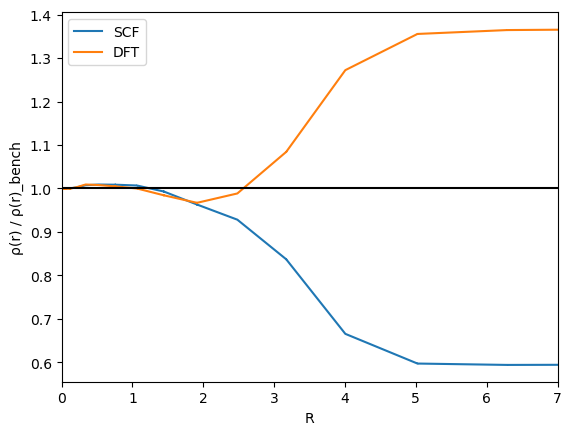

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x14f0a4990>

In [5]:
data_dict = Dict("SCF" => data[1], "DFT" => data[2])
plot_scatter_ratio(data_dict, data[3], R)

## 2. The GRAC Correction
A question then arises: what if we could correct the DFT potential asymptote so that it recovers the correct density and therefore the correction ionization potenital? Effectively, we want to accomplish:

$$v_{\rm{xc}}({\bf r}) = -\frac{1}{r} + v_{\rm{xc}}(\infty).$$

However, having a correct asympote would require knowledge of the exact $v_{\rm{xc}}$ potential. As we operate completely in the Density Funcitonal Approximation domain, this is not a possible task. Instead, the GRAC correction requires that we know our Ionization Potential and we can replace the complex DFT term with the following:

$$v_{\rm{xc}}({\bf r}) = -\frac{1}{r} + (I_{\bf P} + \epsilon_N)$$

Where $\epsilon_N$ is our HOMO energy. This is quite clever as we now only need a functional that correctly goes to the $\frac{1}{r}$ asymptotic. As no general functional accomplishes this task a special functional, "LB94", was built with exactly this property. The downside is that the characteristics of this functional are quite poor in the "bulk" region, or the region near the atom itself. To generalize this a switching function is introduced:

$$
\begin{align}
v_{\rm{xc}}^{GRAC}(\rho({\bf r})) &= [1 - f[x({\bf r})]]v_{\rm{XC}}^{\rm bulk}+ f[x({\bf r})]v_{\rm{XC}}^{\rm Asym.}  \\ \\
f[x({\bf r})] &= \frac{1}{1 + e^{-\alpha[x({\bf r}) - \beta]}}\\\\
x({\bf r}) &= \frac{| \nabla \rho({\bf r}) | }{\rho^\frac{4}{3}({\bf r})}
\end{align}
$$


We seamlessly switch between the bulk and asymptotic potenitals. In addition, such a formulation allows us to apply the GRAC correction to any underlying functional in a general way.


In [6]:
# Build a LB 94 functional
lb94_func = psi4.core.SuperFunctional.blank()
lb94_func.set_max_points(500000)
lb94_func.set_deriv(1)

# Add member functionals
tmp_func = psi4.core.LibXCFunctional("XC_GGA_X_LB", true)
# We need to scale this for the amount of exact exchange is in the functional
tmp_func.set_alpha(0.75)
lb94_func.add_x_functional(tmp_func)

# Dont forget VWN correlation!
tmp_func = psi4.core.LibXCFunctional("XC_LDA_C_VWN", true)
lb94_func.add_c_functional(tmp_func)

# Allocate the functional
lb94_func.allocate()

grac_shift = (21.5645 - dft_ip) /  psi4.constants.hartree2ev

"""
Computes the XC energy and the V_xc Fock term
"""
function compute_V_GRAC(D, Vpot)
    
    grac_alpha = 0.5
    grac_beta = 40.0

    nbf = D.shape[1]
    Varr = zeros(nbf, nbf)

    points_func = Vpot.properties()[1]
    superfunc = Vpot.functional()
    
    total_e = 0.0
    
    for x in 1:Vpot.nblocks()

        # Grid data
        grid = Vpot.get_block(x-1)
        w = np.array(grid.w())
        #npoints = w.shape[1]
        npoints = size(w)[1]

        points_func.compute_points(grid)
        lpos = np.array(grid.functions_local_to_global()) .+ 1
        #nfunctions = lpos.shape[1]
        nfunctions = size(lpos)[1]
        
        phi = np.array(points_func.basis_values()["PHI"])[1:npoints, 1:nfunctions]
        
        rho = np.array(points_func.point_values()["RHO_A"])[1:npoints]
        gamma = np.array(points_func.point_values()["GAMMA_AA"])[1:npoints]

        grac_x = @. (gamma^0.5) / (rho^(4.0/3.0))
        #grac_fx = 1.0 ./ (1.0 .+ np.exp(-grac_alpha .* (grac_x .- grac_beta)))
        grac_fx = @. 1.0 / (1.0 + np.exp(-grac_alpha * (grac_x - grac_beta)))
        
        ret = superfunc.compute_functional(points_func.point_values(), -1)
        lbret = lb94_func.compute_functional(points_func.point_values(), -1)
        
        #total_e += np.vdot(np.array(ret["V"])[1:npoints], w)
        total_e += dot(np.array(ret["V"])[1:npoints], w)
        
        v_rho_a  = @. ( 1 - grac_fx ) * (np.array(ret["V_RHO_A"])[1:npoints] - grac_shift)
        v_rho_a += @. grac_fx * np.array(lbret["V_RHO_A"])[1:npoints]
        v_rho_a .*= 0.5 .* w
        
        Vtmp = np.einsum("pb,p,pa->ab", phi, v_rho_a, phi, optimize=true)

        # GGA
        rho_x = np.array(points_func.point_values()["RHO_AX"])[1:npoints]
        rho_y = np.array(points_func.point_values()["RHO_AY"])[1:npoints]
        rho_z = np.array(points_func.point_values()["RHO_AZ"])[1:npoints]
        
        phi_x = np.array(points_func.basis_values()["PHI_X"])[1:npoints, 1:nfunctions]
        phi_y = np.array(points_func.basis_values()["PHI_Y"])[1:npoints, 1:nfunctions]
        phi_z = np.array(points_func.basis_values()["PHI_Z"])[1:npoints, 1:nfunctions]
        
        v_gamma  = @. (1 - grac_fx) * np.array(ret["V_GAMMA_AA"])[1:npoints]
        v_gamma .*= 2.0 .* w
        Vtmp += np.einsum("pb,p,p,pa->ab", phi, v_gamma, rho_x, phi_x, optimize=true)
        Vtmp += np.einsum("pb,p,p,pa->ab", phi, v_gamma, rho_y, phi_y, optimize=true)
        Vtmp += np.einsum("pb,p,p,pa->ab", phi, v_gamma, rho_z, phi_z, optimize=true)

        
        #Varr[(lpos[:, None], lpos)] += Vtmp + Vtmp.T
        Varr[lpos, lpos] += Vtmp + Vtmp'

    end
    total_e, Varr
end

# Test our function the the handy ks solver.
grac_e, grac_data = ks_solver("PBE0", mol, options, compute_V_GRAC)       


Number of occupied orbitals: 5
Number of basis functions:   23

Starting SCF iterations:

    Iter            Energy             XC E         Delta E        D RMS

SCF Iter  1: -122.77932612141758   -11.5580423   -1.22779E+02   1.55466E-01
SCF Iter  2: -117.35576551166128    -6.4504083   5.42356E+00   1.89487E-01
SCF Iter  3: -128.68766707945355    -9.7183972   -1.13319E+01   2.91504E-02
SCF Iter  4: -128.80683742064261    -9.4890898   -1.19170E-01   1.05122E-02
SCF Iter  5: -128.82176520990396    -9.3901802   -1.49278E-02   1.39167E-03
SCF Iter  6: -128.82218546709356    -9.3740660   -4.20257E-04   3.33912E-05
SCF Iter  7: -128.82219002585751    -9.3743046   -4.55876E-06   1.71356E-06
SCF Iter  8: -128.82218988268602    -9.3743231   1.43171E-07   3.24981E-08

Final SCF energy: -128.82218988 hartree 


(-128.82218988268602, Dict{Any,Any}("eigenvalues" => PyObject <psi4.core.Vector object at 0x15423d110>,"Da" => PyObject <psi4.core.Matrix object at 0x15423d290>,"Ca" => PyObject <psi4.core.Matrix object at 0x15423d170>))

We can now check against the Psi4 reference implementation. Note that we set the GRAC shift on either side of the computation so that we do not contaminate other computations.

In [7]:
psi4.set_options(Dict("dft_grac_shift" => grac_shift))
print(psi4.energy("PBE0"))
psi4.set_options(Dict("dft_grac_shift" => 0.0))

-128.82218989858404

## 3. Inspecting the outcome
Now that we applied the GRAC shift we can observe the density and see how well we do.

In [8]:
#grac_ip = -1 * grac_data["eigenvalues"].np[dft_wfn.nalpha()-1] * psi4.constants.hartree2ev
grac_ip = -1 * grac_data["eigenvalues"].np[dft_wfn.nalpha()] * psi4.constants.hartree2ev

println("Neon Ionization Potential (eV)")
printfmt("SCF     {:10.4f}\n", scf_ip)
printfmt("PBE0    {:10.4f}\n", dft_ip)
printfmt("PBE0-AC {:10.4f}\n", grac_ip)
printfmt("CISD    {:10.4f}\n", ci_ip)
printfmt("NIST    {:10.4f}\n", 21.5645)

Neon Ionization Potential (eV)
SCF        23.2125
PBE0       16.0362
PBE0-AC    21.4275
CISD       22.2776
NIST       21.5645


We observe that our ionization potenital is now much closer to the correct ionization potenital and while the density is not perfect, it is much closer to the CISD density.

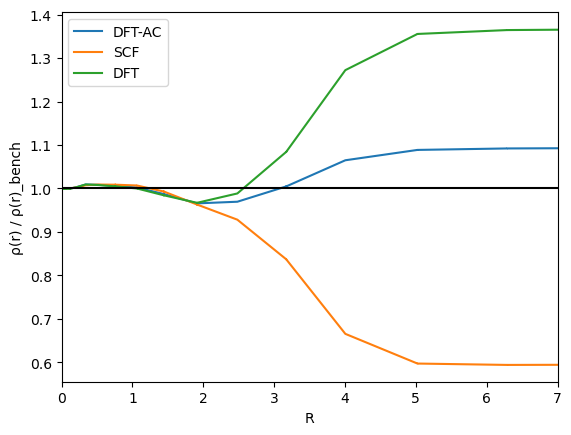

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x1542affd0>

In [9]:
R, data = one_electron_radial([scf_wfn.Da(), dft_wfn.Da(), grac_data["Da"], ci_wfn.Da()], Vpot)
data_dict = Dict("SCF"=> data[1], "DFT"=> data[2], "DFT-AC"=> data[3])
plot_scatter_ratio(data_dict, data[4], R)

Refs:
 - M. Gruning, O. V. Gritsenko, S. J. A. van Gisbergen, and E. J. BaerendsJ. Chem. Phys., **2001**, *114*, 652